In [1]:
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import pandas as pd
import os
import json
from glob import glob
from PIL import Image
import pickle

# image preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input

# tf layers
from tensorflow.keras.layers import Dense, LSTM, Embedding #, GRU

In [2]:
# Read the json file containing annotations
annotation_file = '/home/ethuer/Blog/blogposts/Deeplearning/show-attend-and-tell_tf2/train/captions_train2017.json'
PATH = '/home/ethuer/Blog/blogposts/Deeplearning/show-attend-and-tell_tf2/train/' #train2017/
with open(annotation_file, 'r') as f:
    annotations = json.load(f)



In [3]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    filename = '%012d.jpg' %  annot['image_id'] # add to image format
    full_coco_image_path = PATH +'train2017/' + filename 
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)


In [4]:
len(train_captions), len(all_captions)

(591753, 591753)

## Preprocess the images using VGG16

In [5]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE,IMG_SIZE))
    img = preprocess_input(img)
    return img, image_path

In [6]:

vgg16_feature_extraction = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



#image_features_extract_model = tf.keras.Model(image_model.input, image_model.output)

In [7]:
# The model ends in a feature layer of shape 5, 5, 512,  we will turn this into a 25,512 feature tensor
vgg16_feature_extraction.layers[-1].output.shape

TensorShape([None, 5, 5, 512])

In [8]:
# each image has 5 labels ( 312 images have 6 ). Differently worded descriptions of the same image
encode_train = sorted(set(all_img_name_vector))

In [9]:
encode_train[0:2]

['/home/ethuer/Blog/blogposts/Deeplearning/show-attend-and-tell_tf2/train/train2017/000000000009.jpg',
 '/home/ethuer/Blog/blogposts/Deeplearning/show-attend-and-tell_tf2/train/train2017/000000000025.jpg']

In [10]:

# Create a tf. Dataset from the encoded data
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image).batch(32)


In [11]:
image_dataset.take(1)

<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.string)>

In [12]:
# test the image dataset
for count,(img, path) in enumerate(image_dataset):
    if count ==0:
        i = img 
        p = path
    else:
        break
        
test_img = vgg16_feature_extraction(i)
reshaped_test_batch = tf.reshape(test_img, (test_img.shape[0], -1, test_img.shape[3]))

In [13]:
print(f"The image Model (VGG16) returns tensors of shape {str(test_img.shape)} , after reshaping we get {str(reshaped_test_batch.shape)} " ) 

The image Model (VGG16) returns tensors of shape (32, 5, 5, 512) , after reshaping we get (32, 25, 512) 


In [15]:
# Daten werden Lokal mittels VGG16 vorbearbeiter und ausgeschrieben.
for img, path in image_dataset:
    batch_features = vgg16_feature_extraction(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    # buffer the data in numpy files
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* Zunächst werden die Sätze Tokenisiert ( in Worte zerschnitten)
* Unbekannte Worte werden durch UNK Token ersetzt
* Tensorflow word tokenizer generiert dann die Sätze in Integer sequenzen
* Danach werden die Sätze auf eine gemeinsame Länge gebracht

In [16]:
# Analyzing the model text  
# train_captions

In [17]:
top_k = 6000 
unwanted_characters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,                                              
                                                  oov_token="<unk>",
                                                  filters=unwanted_characters)
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# extend word2index and index2word with a padding sequence
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
word_data = pd.DataFrame.from_dict( {'count':tokenizer.word_counts}, orient='columns')

In [19]:
word_data.sort_values('count', ascending=False, inplace=True)

In [20]:
#word_data[0].describe( percentiles= [ (1-(6000/word_data.shape[0])), (1-(5000/word_data.shape[0])), (1-(4000/word_data.shape[0]))])
# 6000 words includes 
for n in [4000,5000,6000,7000]:
    print(f'Using the top {n} words, we retain words with a count over {word_data.iloc[n][0]} Occurances' )
#word_data.loc[word_data[0] > 10].shape[0]


Using the top 4000 words, we retain words with a count over 37 Occurances
Using the top 5000 words, we retain words with a count over 23 Occurances
Using the top 6000 words, we retain words with a count over 15 Occurances
Using the top 7000 words, we retain words with a count over 11 Occurances


In [21]:
allowed_vocabulary = word_data[0:top_k].index.tolist()
allowed_vocabulary.append('<pad>')

Text(0.5, 1.0, 'Word count')

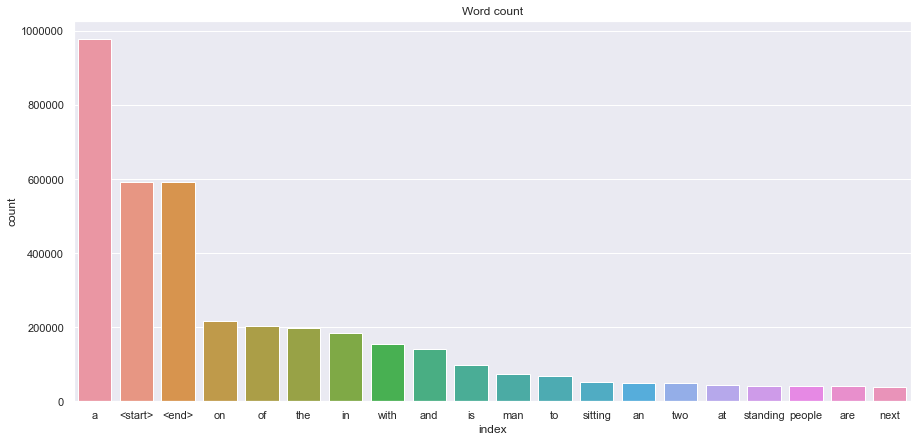

In [22]:
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.barplot(x='index',  y='count', data = word_data.reset_index()[:20])
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Word count')

In [23]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# check lenghts
train_length = [len(x) for x in train_seqs]

[Text(0, 0.5, 'Anzahl'), Text(0.5, 0, 'Satzlänge')]

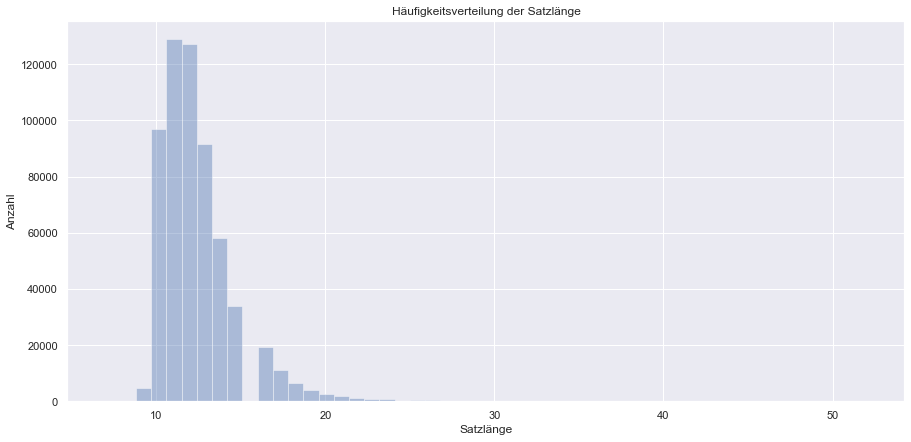

In [24]:
ax = sns.distplot( pd.DataFrame({'len':train_length}) , kde=False)
ax.set_title('Häufigkeitsverteilung der Satzlänge')
ax.set(xlabel='Satzlänge', ylabel='Anzahl')

In [25]:
pd.DataFrame({'len':train_length}).describe(percentiles=[.90,.985,.99])

,len
count,591753.000000
mean,12.468599
std,2.400089
min,7.000000
50%,12.000000
90%,15.000000
98.5%,20.000000
99%,21.000000
max,52.000000


In [26]:
# 98.5% of sequences are less than 20.000000 long.  Use 20 as a maximum lenght

In [27]:
# Pad each vector to 20
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=20)

## Split the data into training and testing

In [28]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, train_seqs, val_seqs = train_test_split(img_name_vector,
                                                                    train_seqs,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [29]:
len(img_name_train), len(train_seqs), len(img_name_val), len(val_seqs)

(473402, 473402, 118351, 118351)

# Load GLoVe embedding

In [30]:
EMBED_DIM  = 300

In [31]:
import itertools

In [32]:
word2idx_topk = {}
for word, vec in tokenizer.word_index.items():
    if word in allowed_vocabulary:
        word2idx_topk[word] = vec

In [33]:
word2idx_topk

{'a': 2,
 '<start>': 3,
 '<end>': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'at': 17,
 'standing': 18,
 'people': 19,
 'are': 20,
 'next': 21,
 'white': 22,
 'woman': 23,
 'street': 24,
 'table': 25,
 'holding': 26,
 'that': 27,
 'large': 28,
 'it': 29,
 'person': 30,
 'some': 31,
 'down': 32,
 'top': 33,
 'group': 34,
 'up': 35,
 'field': 36,
 'small': 37,
 'tennis': 38,
 'near': 39,
 'front': 40,
 'his': 41,
 'black': 42,
 'train': 43,
 'plate': 44,
 'room': 45,
 'dog': 46,
 'riding': 47,
 'red': 48,
 'cat': 49,
 'young': 50,
 'by': 51,
 'water': 52,
 'baseball': 53,
 'has': 54,
 'while': 55,
 'playing': 56,
 'walking': 57,
 'bathroom': 58,
 'sign': 59,
 'blue': 60,
 'kitchen': 61,
 'food': 62,
 'grass': 63,
 'there': 64,
 'bus': 65,
 'green': 66,
 'pizza': 67,
 'parked': 68,
 'side': 69,
 'building': 70,
 'other': 71,
 'bed': 72,
 'looking': 73,
 'snow': 74,
 'beach': 75,
 'ball': 76,

In [34]:

# load embedding from file
embedded_words = {}
with open('embeddings/GloVe.6B.200d/glove.6B.300d.txt', 'r' ) as glove_file:
    for (i, line) in enumerate(glove_file):
        split = line.split(' ')
            
        word = split[0]
        representation = split[1:]
        representation = np.array([float(val) for val in representation] )
        
        embedded_words[word] = representation


# create an embedding matrix from only the known words
EMBEDDING_MATRIX = np.zeros((len(word2idx_topk) , EMBED_DIM))


for word, idx  in word2idx_topk.items():
    if word in embedded_words:
        if idx < EMBEDDING_MATRIX.shape[0]:
            EMBEDDING_MATRIX[idx] = embedded_words[word]
    elif word == '<stop>':
        EMBEDDING_MATRIX[idx] = embedded_words['stop']
    elif word == '<start>':
        EMBEDDING_MATRIX[idx] = embedded_words['start']
    elif word == '<pad>':
        #EMBEDDING_MATRIX[word] = np.zeros(300)
        EMBEDDING_MATRIX[idx] = embedded_words['pad']
    elif word == '<unk>':
        EMBEDDING_MATRIX[idx] = embedded_words['unknown']
    else:
        # words not in the embedding matrix are set to zeros
        EMBEDDING_MATRIX[idx] = np.zeros(300)

## Create a tf.data dataset for training


In [35]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBED_DIM = 300

units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from VGG is (25 (5x5), 512)
features_shape = 512
attention_features_shape = 25

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, train_seqs))

In [37]:
# Load the numpy files
def map_image(img_name, sentence):
    """ image name to tensor """
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, sentence


# Use map to load the numpy files
dataset = dataset.map(lambda image_name, sentence: tf.numpy_function(
          map_image, [image_name, sentence], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE) # load in parallel

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Die Architektur folgt in etwa [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) sowie dem Tensorflow [Exposé](https://www.tensorflow.org/tutorials/text/image_captioning) .

* Features kommen aus dem letzten convolutional layer des VGG16
* Reshape zu (25, 512).
* Danach läuft das ganze durch einen CNN Encoder.
* The RNN (LSTM) verwendet Attention mapping via [Bahdanau](https://arxiv.org/pdf/1409.0473.pdf).

In [52]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, feature_size, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        
        # Bahdanau adds a time axis for orientation
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # And a scoring system
        # score shape == (batch_size, 25 , hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # get the attention weights,  (softmax) apply score to self.V 
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [53]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, EMBED_DIM):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 25, embedding_dim)
        self.fc = Dense(EMBED_DIM) #, activation='relu'

    def call(self, x):
        
        
        x = self.fc(x)
        
        
        
        x = tf.nn.relu(x)
        return x

In [54]:
EMBEDDING_MATRIX.shape

(6001, 300)

In [55]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # Preset the embedding weights
        self.embedding = Embedding(vocab_size, 
                                               embedding_dim,
                                               embeddings_initializer =tf.keras.initializers.Constant(EMBEDDING_MATRIX), 
                                               trainable=False 
                                  )
        
        self.LSTM = LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        
        
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, _ , state = self.LSTM(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [56]:
units = 300
encoder = CNN_Encoder(EMBED_DIM)
decoder = RNN_Decoder(EMBED_DIM, units, vocab_size)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [58]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [59]:
start_epoch = 0
#if ckpt_manager.latest_checkpoint:
#    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
#    ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

Der Output des Encoders , hidden states(initialisiert zu 0) und der Decoder input (start token) werden an den Decoder gereicht.

Dieser macht vorhersagen und gibt den hidden state zurück um den Loss zu berechnen.

Sogenanntes 'Teacher foring' wird verwendet um den Decoder zu trainieren. Dabei wird dem Decoder das reale nächste Label als Trainingsziel gereicht.



In [60]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # create an empty sequence with a start token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        # VGG features + 1 dense layer
        
        features = encoder(img_tensor)

        # For every word in the target sentence
        for i in range(1, target.shape[1]):
            
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # Teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [61]:
#!pip install --upgrade numpy

In [62]:
EPOCHS = 2
loss_plot = []

for epoch in range(start_epoch, EPOCHS):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):

        batch_loss, t_loss = train_step(img_tensor, target)

        total_loss += t_loss

        if batch % 100 == 0:
            if batch % 1000 == 0:
                print (f'Epoch {epoch + 1} Batch {batch} Loss { batch_loss.numpy() / int(target.shape[1])}')
            loss_plot.append(batch_loss.numpy() / int(target.shape[1]))
                   
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.819198226928711
Epoch 1 Batch 1000 Loss 1.970599365234375
Epoch 1 Batch 2000 Loss 1.986009407043457
Epoch 1 Batch 3000 Loss 1.9780179977416992
Epoch 1 Batch 4000 Loss 1.9057872772216797
Epoch 1 Batch 5000 Loss 1.896417999267578
Epoch 1 Batch 6000 Loss 2.133236312866211
Epoch 1 Batch 7000 Loss 1.6321372985839844


InvalidArgumentError: ValueError: Cannot load file containing pickled data when allow_pickle=False
Traceback (most recent call last):

  File "/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/script_ops.py", line 236, in __call__
    ret = func(*args)

  File "<ipython-input-37-c51acc346937>", line 4, in map_image
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')

  File "/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/npyio.py", line 457, in load
    raise ValueError("Cannot load file containing pickled data "

ValueError: Cannot load file containing pickled data when allow_pickle=False


	 [[{{node PyFunc}}]]

In [68]:
loss = pd.DataFrame({'loss':loss_plot})

Text(0.5, 1.0, 'Loss')

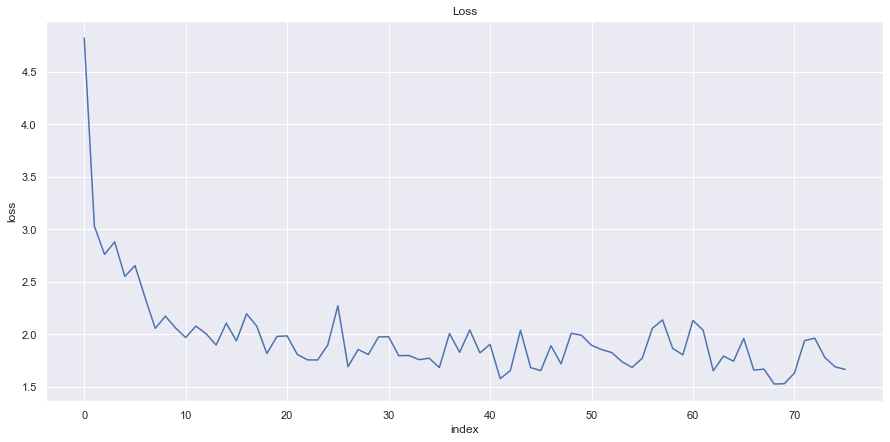

In [72]:
ax = sns.lineplot(x='index', y='loss',data=loss.reset_index())
ax.set_title('Loss')

## Phrasikon

Das Modell generiert nun eigenständig Labels zu den Bildern.


In [73]:
attention_features_shape = 25
max_length = 20

In [74]:
# Load the numpy files
def map_image(img_name, sentence):
    """ image name to tensor """
    img_tensor = np.load(img_name+'.npy')
    return img_tensor, sentence

In [118]:
import random
def generate_results():
    idx = random.randint(0,1000)
    img_tensor_val, sent =map_image(img_name_val[idx],val_seqs[idx] ) 
    
    features = encoder(img_tensor_val)
    hidden = decoder.reset_state(batch_size=1)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        if not tokenizer.index_word[predicted_id] == 'a':
            result.append(tokenizer.index_word[predicted_id])
        
    return img_name_val[idx], result

In [120]:
from IPython.display import Image

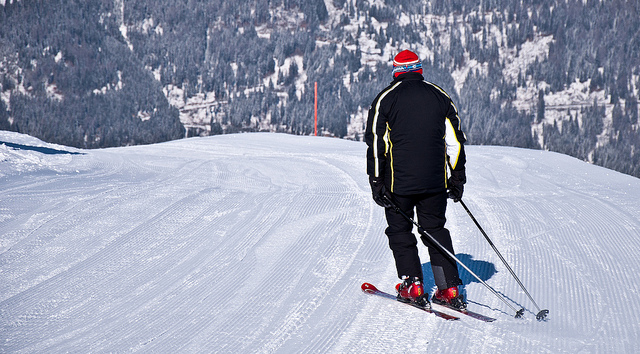

In [149]:
img, tags = generate_results()
Image(filename=img) 


In [150]:
print(tags)

['person', 'there', 'this', 'of', 'skier', 'red']
